Loading data...
train shape: (8000, 7), test shape: (2000, 6)

Columns: ['Id', 'Therapy Hours', 'Initial Health Score', 'Lifestyle Activities', 'Average Sleep Hours', 'Follow-Up Sessions', 'Recovery Index']

Train head:
     Id  Therapy Hours  Initial Health Score Lifestyle Activities  \
0  9255              5                    49                   No   
1  1562              2                    48                  Yes   
2  1671              2                    81                   No   
3  6088              2                    46                   No   
4  6670              8                    47                   No   

   Average Sleep Hours  Follow-Up Sessions  Recovery Index  
0                    7                   5              36  
1                    7                   6              25  
2                    7                   2              59  
3                    6                   1              22  
4                    9                   0              40  

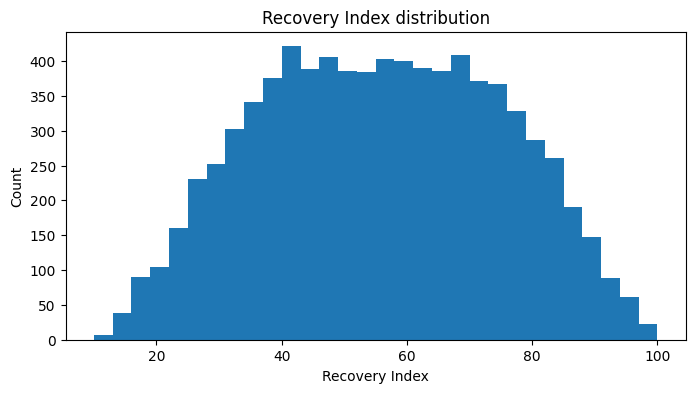


Missing values in train:
                      missing_count  missing_pct
Id                                0          0.0
Therapy Hours                     0          0.0
Initial Health Score              0          0.0
Lifestyle Activities              0          0.0
Average Sleep Hours               0          0.0
Follow-Up Sessions                0          0.0
Recovery Index                    0          0.0

Missing values in test:
                      missing_count  missing_pct
Id                                0          0.0
Therapy Hours                     0          0.0
Initial Health Score              0          0.0
Lifestyle Activities              0          0.0
Average Sleep Hours               0          0.0
Follow-Up Sessions                0          0.0

Numeric features correlation with target:
Recovery Index          1.000000
Initial Health Score    0.914718
Therapy Hours           0.376255
Average Sleep Hours     0.044435
Follow-Up Sessions      0.043888
Id    

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomForest best RMSE (cv): 2.2045082713367723 params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10}
Tuning Gradient Boosting (RandomizedSearchCV)...
GradientBoosting best RMSE (cv): 2.1427923283440506 params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}
Tuning XGBoost (RandomizedSearchCV)...
XGBoost best RMSE (cv): 2.139436694231006 params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

--- CV results summary ---
Ridge: RMSE=2.09509, params={'alpha': 0.01}
Lasso: RMSE=2.09511, params={'alpha': 0.0001}
ElasticNet: RMSE=2.09642, params={'alpha': 0.0005, 'l1_ratio': 0.9}
RandomForest: RMSE=2.20451, params={'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10}
GradientBoosting: RMSE=2.14279, params={'n_estimators': 400, 'min_samples_split': 2, 'min_sa

In [ ]:
"""

Patient Recovery Predictive Modeling Pipeline
Initial Baseline Models 

This notebook serves as our initial baseline for the Patient Recovery Prediction challenge. It uses a set of basic11 engineered features to train and evaluate a range of standard regression models.

The models evaluated in this pass include:

Ridge

Lasso

ElasticNet

RandomForestRegressor

GradientBoostingRegressor

XGBRegressor

The goal is to establish a preliminary performance benchmark. Based on cross-validation, the Ridge regression model yielded the lowest Root Mean Squared Error (RMSE) in this initial comparison.

"""

# --- Imports and settings -------------------------------------------------
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
# from sklearn.externals import joblib if hasattr(__import__('sklearn'), 'externals') else None

# Try import xgboost gracefully
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False



INPUT_DIR = Path('/kaggle/input/Patient-Recovery-Prediction-Challenge')
OUTPUT_DIR = Path('/kaggle/working/')

TRAIN_PATH = INPUT_DIR / 'train.csv'
TEST_PATH = INPUT_DIR / 'test.csv'
SAMPLE_SUB_PATH = INPUT_DIR / 'sample_submission.csv'

# Output files should be saved in the /kaggle/working/ directory
OUTPUT_PRED = OUTPUT_DIR / 'submission.csv'
BEST_MODEL_PATH = OUTPUT_DIR / 'best_model.joblib'

RANDOM_STATE = 42
N_JOBS = -1

# --- Utility functions ---------------------------------------------------

def rmse_cv(model, X, y, cv=5):
    """Return RMSE (averaged) from cross_val_score (negative RMSE scoring)."""
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=N_JOBS)
    return -scores.mean()


def describe_missing(df):
    miss = df.isnull().sum()
    miss_pct = (miss / len(df)) * 100
    return pd.concat([miss, miss_pct], axis=1, keys=['missing_count', 'missing_pct']).sort_values('missing_count', ascending=False)

# --- Load data -----------------------------------------------------------
print('Loading data...')
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print(f'train shape: {train.shape}, test shape: {test.shape}')
print('\nColumns:', train.columns.tolist())

# Quick glance
print('\nTrain head:')
print(train.head())

# --- Basic EDA ----------------------------------------------------------
print('\n--- EDA Summary ---')
print('\nTarget variable summary:')
print(train['Recovery Index'].describe())

# Target distribution
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.hist(train['Recovery Index'], bins=30)
    plt.title('Recovery Index distribution')
    plt.xlabel('Recovery Index')
    plt.ylabel('Count')
    plt.show()
except Exception:
    pass

# Missing values
print('\nMissing values in train:')
print(describe_missing(train))
print('\nMissing values in test:')
print(describe_missing(test))

# Correlation with target for numeric features (train)
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Recovery Index')
print('\nNumeric features correlation with target:')
print(train[numeric_cols + ['Recovery Index']].corr()['Recovery Index'].sort_values(ascending=False))

# Check distributions and basic stats
print('\nNumeric summary:')
print(train[numeric_cols].describe().T)

# Categorical value counts
if 'Lifestyle Activities' in train.columns:
    print('\nLifestyle Activities distribution:')
    print(train['Lifestyle Activities'].value_counts(dropna=False))

# --- Preprocessing & Feature Engineering --------------------------------
print('\n--- Preprocessing and Feature Engineering ---')
# We'll combine train and test to ensure consistent pre-processing
train['is_train'] = 1
test['is_train'] = 0

# Keep target separately
y = train['Recovery Index'].copy()
train.drop(columns=['Recovery Index'], inplace=True)

combined = pd.concat([train, test], axis=0, ignore_index=True)
print('Combined shape:', combined.shape)

# Standardize column names
combined.columns = [c.strip().replace(' ', '_').lower() for c in combined.columns]

# Re-inspect columns
print('Columns after rename:', combined.columns.tolist())

# Rename helpful variables
# Expected columns (after rename): therapy_hours, initial_health_score, lifestyle_activities, average_sleep_hours, follow-up_sessions -> follow_up_sessions
combined.rename(columns={'follow-up_sessions': 'follow_up_sessions'}, inplace=True)

# Basic cleaning: map lifestyle activities to binary
if 'lifestyle_activities' in combined.columns:
    combined['lifestyle_activities'] = combined['lifestyle_activities'].map({'Yes': 1, 'No': 0})

# Feature engineering: interaction terms and ratios
combined['therapy_x_initial'] = combined['therapy_hours'] * combined['initial_health_score']
combined['sleep_x_initial'] = combined['average_sleep_hours'] * combined['initial_health_score']
combined['therapy_per_followup'] = combined['therapy_hours'] / (combined['follow_up_sessions'] + 1)
combined['sleep_per_therapy'] = combined['average_sleep_hours'] / (combined['therapy_hours'] + 0.01)

# Binning initial health score into categories
combined['initial_health_bin'] = pd.qcut(combined['initial_health_score'].rank(method='first'), q=4, labels=False)  # 0-3 quartiles

# Flag for low sleep
combined['low_sleep_flag'] = (combined['average_sleep_hours'] < 6).astype(int)

# Winsorize (clip) extreme outliers for continuity
for col in ['therapy_hours', 'initial_health_score', 'average_sleep_hours', 'follow_up_sessions', 'therapy_x_initial']:
    if col in combined.columns:
        lower = combined[col].quantile(0.01)
        upper = combined[col].quantile(0.99)
        combined[col] = combined[col].clip(lower, upper)

# Show engineered features distribution sample
print('\nEngineered features sample:')
print(combined[['therapy_x_initial', 'sleep_x_initial', 'therapy_per_followup', 'sleep_per_therapy', 'initial_health_bin', 'low_sleep_flag']].head())

# --- Handling missing values --------------------------------------------
print('\n--- Handling missing values ---')
print(describe_missing(combined))

# Decide column types
num_features = combined.select_dtypes(include=[np.number]).columns.tolist()
cat_features = combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove utility columns
if 'is_train' in num_features:
    num_features.remove('is_train')
if 'id' in num_features:
    num_features.remove('id')

# Some engineered features are numeric and included; keep them
print('Numeric features count:', len(num_features))
print('Categorical features:', cat_features)

# Fill missing strategy:
# - Numeric: median
# - Categorical: constant 'missing'

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# Column transformer for preprocessing
# For numeric features, apply imputation + power transformer + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', numeric_imputer),
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', RobustScaler())
])

# For categorical (if any), impute and one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# Prepare final train/test matrices
combined_processed = combined.copy()

# Preserve IDs
if 'id' in combined_processed.columns:
    ids = combined_processed['id']
else:
    ids = pd.Series(np.arange(len(combined_processed)), name='id')

# Fit preprocessor only on combined to ensure no leakage (it does include test too)
print('\nFitting preprocessor to combined data (numerics + categoricals)...')
preprocessor.fit(combined_processed.drop(columns=['is_train']))
X_all = preprocessor.transform(combined_processed.drop(columns=['is_train']))

# Get feature names after transformation for feature importance mapping
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
            # OneHotEncoder
            ohe = transformer.named_steps['onehot']
            cols = list(columns)
            ohe_names = ohe.get_feature_names_out(cols)
            feature_names.extend(list(ohe_names))
        else:
            cols = list(columns)
            feature_names.extend(cols)
    return feature_names

try:
    feature_names = get_feature_names_from_column_transformer(preprocessor)
except Exception:
    # Generic fallback to numeric + categorical names
    feature_names = num_features + cat_features

print('Number of transformed features:', len(feature_names))

# Split back into train and test
X_combined = pd.DataFrame(X_all.toarray() if hasattr(X_all, 'toarray') else X_all, columns=feature_names)
X_combined['is_train'] = combined['is_train'].values

X_train = X_combined[X_combined['is_train'] == 1].drop(columns=['is_train']).reset_index(drop=True)
X_test = X_combined[X_combined['is_train'] == 0].drop(columns=['is_train']).reset_index(drop=True)

# Ensure shapes match
print('Processed X_train shape:', X_train.shape)
print('Processed X_test shape:', X_test.shape)

# Align y index
y = y.reset_index(drop=True)
print('y shape:', y.shape)

# --- Feature selection (optional) --------------------------------------
# Use a simple model-based selection (Lasso) to remove extremely unimportant features
print('\n--- Feature selection via Lasso (sparse model) ---')
feat_selector = Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=20000)
try:
    feat_selector.fit(X_train, y)
    importances = np.abs(feat_selector.coef_)
    keep_idx = np.where(importances > 1e-4)[0]
    print(f'Retaining {len(keep_idx)} features out of {X_train.shape[1]}')
    X_train_sel = X_train.iloc[:, keep_idx]
    X_test_sel = X_test.iloc[:, keep_idx]
    selected_feature_names = X_train_sel.columns.tolist()
except Exception as e:
    print('Feature selection failed, skipping. Error:', e)
    X_train_sel = X_train
    X_test_sel = X_test
    selected_feature_names = X_train_sel.columns.tolist()

# --- Model building and hyperparameter tuning ---------------------------
print('\n--- Model training and hyperparameter tuning ---')
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}

# 1) Ridge
ridge = Ridge(random_state=RANDOM_STATE)
ridge_params = {'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 50.0]}
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=N_JOBS)
print('Tuning Ridge...')
ridge_grid.fit(X_train_sel, y)
results['Ridge'] = {'best_score': -ridge_grid.best_score_, 'best_params': ridge_grid.best_params_}
print('Ridge best RMSE (cv):', -ridge_grid.best_score_, 'params:', ridge_grid.best_params_)

# 2) Lasso
lasso = Lasso(random_state=RANDOM_STATE, max_iter=20000)
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
lasso_grid = GridSearchCV(lasso, lasso_params, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=N_JOBS)
print('Tuning Lasso...')
lasso_grid.fit(X_train_sel, y)
results['Lasso'] = {'best_score': -lasso_grid.best_score_, 'best_params': lasso_grid.best_params_}
print('Lasso best RMSE (cv):', -lasso_grid.best_score_, 'params:', lasso_grid.best_params_)

# 3) ElasticNet
elastic = ElasticNet(random_state=RANDOM_STATE, max_iter=20000)
elastic_params = {'alpha': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'l1_ratio': [0.2, 0.5, 0.7, 0.9]}
elastic_grid = GridSearchCV(elastic, elastic_params, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=N_JOBS)
print('Tuning ElasticNet...')
elastic_grid.fit(X_train_sel, y)
results['ElasticNet'] = {'best_score': -elastic_grid.best_score_, 'best_params': elastic_grid.best_params_}
print('ElasticNet best RMSE (cv):', -elastic_grid.best_score_, 'params:', elastic_grid.best_params_)

# 4) Random Forest (RandomizedSearchCV)
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5]
}
print('Tuning Random Forest (RandomizedSearchCV)...')
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=25, scoring='neg_root_mean_squared_error', cv=cv, random_state=RANDOM_STATE, n_jobs=N_JOBS)
rf_search.fit(X_train_sel, y)
results['RandomForest'] = {'best_score': -rf_search.best_score_, 'best_params': rf_search.best_params_}
print('RandomForest best RMSE (cv):', -rf_search.best_score_, 'params:', rf_search.best_params_)

# 5) Gradient Boosting (sklearn)
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
print('Tuning Gradient Boosting (RandomizedSearchCV)...')
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=20, scoring='neg_root_mean_squared_error', cv=cv, random_state=RANDOM_STATE, n_jobs=N_JOBS)
gb_search.fit(X_train_sel, y)
results['GradientBoosting'] = {'best_score': -gb_search.best_score_, 'best_params': gb_search.best_params_}
print('GradientBoosting best RMSE (cv):', -gb_search.best_score_, 'params:', gb_search.best_params_)

# 6) XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=1)
    xgb_params = {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    print('Tuning XGBoost (RandomizedSearchCV)...')
    xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=30, scoring='neg_root_mean_squared_error', cv=cv, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    xgb_search.fit(X_train_sel, y)
    results['XGBoost'] = {'best_score': -xgb_search.best_score_, 'best_params': xgb_search.best_params_}
    print('XGBoost best RMSE (cv):', -xgb_search.best_score_, 'params:', xgb_search.best_params_)
else:
    print('XGBoost not available in this environment; skipping.')

# --- Summary of results -------------------------------------------------
print('\n--- CV results summary ---')
for model_name, res in results.items():
    print(f"{model_name}: RMSE={res['best_score']:.5f}, params={res['best_params']}")

# Select best model by lowest RMSE
best_model_name = min(results.items(), key=lambda x: x[1]['best_score'])[0]
print('\nBest model by CV RMSE:', best_model_name)

# Instantiate best model with best params
if best_model_name == 'Ridge':
    best_model = Ridge(**results['Ridge']['best_params'], random_state=RANDOM_STATE)
elif best_model_name == 'Lasso':
    best_model = Lasso(**results['Lasso']['best_params'], random_state=RANDOM_STATE, max_iter=20000)
elif best_model_name == 'ElasticNet':
    best_model = ElasticNet(**results['ElasticNet']['best_params'], random_state=RANDOM_STATE, max_iter=20000)
elif best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(**results['RandomForest']['best_params'], random_state=RANDOM_STATE)
elif best_model_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(**results['GradientBoosting']['best_params'], random_state=RANDOM_STATE)
elif best_model_name == 'XGBoost' and XGBOOST_AVAILABLE:
    best_model = XGBRegressor(**results['XGBoost']['best_params'], objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=1)
else:
    raise ValueError('Unexpected best model selection')

# Train best model on entire training set
print('\nTraining best model on full training data...')
best_model.fit(X_train_sel, y)

# Evaluate on training with cross-validated metrics
train_pred = best_model.predict(X_train_sel)
train_rmse = mean_squared_error(y, train_pred, squared=False)
train_mae = mean_absolute_error(y, train_pred)
train_r2 = r2_score(y, train_pred)
print(f'Training performance - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')

# Predict on test
print('\nGenerating predictions on test set...')
preds_test = best_model.predict(X_test_sel)

# If necessary, round or clip predictions to match target constraints (10 to 100, rounded to nearest integer)
preds_test = np.rint(np.clip(preds_test, 10, 100)).astype(int)

# Create submission
if 'id' in combined.columns:
    test_ids = combined[combined['is_train'] == 0]['id'].values
else:
    test_ids = np.arange(len(preds_test))

submission = pd.DataFrame({'id': test_ids, 'Recovery Index': preds_test})
submission.to_csv(OUTPUT_PRED, index=False)
print('Saved submission to', OUTPUT_PRED)

# Save the best model
try:
    import joblib
    joblib.dump(best_model, BEST_MODEL_PATH)
    print('Saved best model to', BEST_MODEL_PATH)
except Exception as e:
    print('Could not save model using joblib. Error:', e)

# Feature importance (if available)
print('\nFeature importance (if supported by model):')
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    imp_df = pd.DataFrame({'feature': selected_feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(40)
    print(imp_df)
elif hasattr(best_model, 'coef_'):
    coefs = best_model.coef_
    imp_df = pd.DataFrame({'feature': selected_feature_names, 'coefficient': coefs})
    imp_df['abs_coef'] = imp_df['coefficient'].abs()
    imp_df = imp_df.sort_values('abs_coef', ascending=False).head(40)
    print(imp_df)
else:
    print('Model does not expose importances/coefs.')

print('\nPipeline complete.')
